<H1> CBL Audio Read </H1> <br> 
 Read in and process Audio files produced by CBL monitor process. 
<hr> 
<H2>Modification history </H2>
<table>
    <tr>
        <th> Modified </th>
        <th> BY </th>
        <th> Reason </th>
    </tr>
    <tr>
        <td> 11-Jun-25</td>
        <td> CBL </td>
        <td> Original </td>
    </tr>
</table>

<hr> 
<H2> References </H2> 
NONE
<H2> Pre-requisites</H2> 
numpy<br>
matplotlib<br>
pyaudio<br>
scipy<br>
sounddevice - which returns data in numpy arrays!<br> 
<hr>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.constants as konst
import pyaudio
import wave
import sounddevice as sd
import scipy  as sp
import struct

In [24]:
class CBLAudio: 
    def __init__(self, Filespec):
        self.Created           = None
        self.Input             = -1
        self.Output            = -1, 
        self.FramesPerBuffer   = 0
        self.SampleRate        = 0
        self.NChannels         = 0
        self.Volume            = 0
        self.AcquisitionLength = 0
        self.Note              = None
        self.WordSize          = 1          # need to add this to the header. number of bytes per integer word. 
        self.Version           = 1          # need to add to the header. 
        self.Error             = False
        self.fd                = None
        self.data              = None

        self.fd = open(Filespec, "rb")
        header_size = self.ReadHeader()

        # how many bytes in the file??
        self.fd.seek(0,2) # got to end of file
        self.DataSizeBytes = self.fd.tell() - header_size   # this will give the size of the data payload. 
        self.fd.seek(header_size)   # position at start of data block.
        
        print('Number of seconds in File: ', Filespec, ' ', int(self.DataSizeBytes/2/self.SampleRate), ' seconds')

    def __str__(self):
        return 'Created: ' + self.Created + '\n Input: ' + str(self.Input) + '\n Output: ' + str(self.Output) +  '\n FramesPerBuffer: ' + str(self.FramesPerBuffer) + '\n SampleRate: ' + str(self.SampleRate) +  '\n NChannels: ' + str(self.NChannels) + '\n Volume: ' + str(self.Volume) +  '\n AcquisitionLength: ' + str(self.AcquisitionLength) + '\n Note: ' + self.Note

    def __del__(self):
        print('close')
        self.fd.close()
        
    def ReadHeader(self):
        """
        Read the header from the audio file and process the results. 
        @param fd - open file containing the binary file etc. 
        @return the size of the header
        """
        # Predefined keywords.
        KeyWords = ['Created: ', 'Input: ', 'Output: ', 'FramesPerBuffer: ', 'SampleRate: ', 'NChannels: ', 'Volume: ', 'AcquisitionLength: ', 'Note: ']
        # rewind
        self.fd.seek(0)
        # the first 4 bytes are the header size. 
        twobytes = self.fd.read(4)
        LW = struct.unpack("I", twobytes)
        self.HeaderSize = LW[0]
        header = self.fd.read(self.HeaderSize)
        #
        # Parse header by searching for specific keywords in the stream. 
        #
        tokens = header.splitlines()  # by \n
        # loop over the individual inputs in the header and put them into the structure. 
        index = 0
        for t in tokens:
            s = str(t)
            i = s.find(': ')
            value = s[i+2:len(s)-1]
            if (index == 0):
                self.Created = value        # string of file creation time UTC
            elif(index == 1):
                self.Input   = int(value)   # Input value, this is really based on hardware configuration. 
            elif(index == 2):
                self.Output  = int(value)   # Output value, ditto
            elif (index == 3):
                self.FramesPerBuffer = int(value) # buffered input size
            elif (index == 4):
                self.SampleRate = int(value)
            elif (index == 5):
                self.NChannels = int(value) # number of channels in data set
            elif (index == 6):
                self.Volume = int(value)
            elif (index==7):
                self.AcquisitionLength = int(value)  # in seconds
            elif (index==8):
                self.Version = int(value)   # version number of program producing data
            elif (index==9):
                self.DataType = int(value)  # Data type 0 - byte, 1 - 16 bit word and so on. 
            elif (index == 10):
                self.Note = value
            
            index = index + 1
        return self.HeaderSize
        
    def ReadFrame(self):
        """
        Read a full Sample rate or 1 second of data.
        """
        # FIXME, this only works for one data size, needs to be dependent on the word definition in the header. 
        DataSize = 2     # bytes per word
        byte_data = self.fd.read(self.SampleRate * DataSize)
        print('bytes: ', len(byte_data))
        # need to turn this into floats. This is fixed to int16 FIXME
        (Ddata) = struct.unpack(str(self.SampleRate)+"h",data)
        return np.copy(Ddata)

    def ReadBlock(self):
        """
        read the entire file.
        """
        
        nwords = int(self.DataSizeBytes) 
        if (self.DataType == 0):
            data_format = str(nwords)+'b'
        elif (self.DataType == 1):
            nwords = int(nwords/2)          # signed 16 bit integer
            data_format = str(nwords)+'h'
        elif (self.DataType == 2):
            nwords = int(nwords/4)          # signed 32 bit integer
            data_format = str(nwords)+'i'
        elif (self.DataType == 3):
            nwords = int(nwords/4)          # signed 32 bit float
            data_format = str(nwords)+'f'
        elif (self.DataType == 3):
            nwords = int(nwords/8)          # signed 64 bit float
            data_format = str(nwords)+'d'

        print('Data format: ', data_format)
        # Position file at start of data payload
        self.fd.seek(self.HeaderSize)
        data = self.fd.read(self.DataSizeBytes)
        (Ddata) = struct.unpack(data_format,data)
        
        return np.copy(Ddata)

    def PlotFFT(self, data, UpperLimit=0):
        NFrames = 1
        FrameWidth = NFrames * self.SampleRate
        print ('N Frames: ', NFrames)
        #
        # Plot result
        # returns a vector of frequencies used by fft,
        # inputs are sample rate and 1/sample rate. 
        # power spectrum, via scipy welch. 'boxcar' means no window,
        # nperseg=len(y) so that fft computed on the whole signal.
        freq2,power2 =sp.signal.welch(data, 
                                  fs = self.SampleRate,        # Sampling rate
                                  window  = 'hamming',
                                  nperseg = FrameWidth,   # length of each segment
                                  scaling = 'spectrum', 
                                  axis=-1, 
                                  average='mean')
        N = len(power2)
        #yy = 10.0*np.log10(power2[1:N]/(const.g*const.g)) 
        plt.plot(freq2[1:N],power2[1:N])

        # limit x to 200Hz
        if (UpperLimit>0):
            plt.xlim(0.0, UpperLimit)
        #plt.ylim(-110.0, -30.0)
        plt.title(self.Note )
        plt.grid()
        plt.xlabel("Frequency (Hz)")
        plt.ylabel("adc") 
        plt.show()
        return freq2, power2
        
    def ProcessFile(self, Filename):
        try:
            with open(Filespec, "rb") as file:
                self.fd = file
                # Process the binary_data (e.g., unpack with the 'struct' module)
                self.ReadHeader()
        except FileNotFoundError:
            print("Error: The file", Filespec, " was not found.")
            self.Error = True
        except Exception as e:
            print(f"An error occurred: {e}")  
            self.Error = True
        

In [35]:
Path = '/Users/clirakis/code/Audio/Accelerometer/'
JulianDay = '181/'
Filename = ['250630_143400_0875.acc', '250630_144606_0885.acc', '250630_150214_0460.acc',
            '250630_162758_0179.acc', '250630_174107_0404.acc'
           ]

In [36]:
# Open a file and process contents. 
# all dates are in UTC
#
# construct full file specification
#
Filespec = Path +  JulianDay + Filename[4]
print('Opening: ', Filespec)
xxx = CBLAudio(Filespec)
print(xxx.Error)
data = xxx.ReadBlock()

Opening:  /Users/clirakis/code/Audio/Accelerometer/181/250630_174107_0404.acc
Number of seconds in File:  /Users/clirakis/code/Audio/Accelerometer/181/250630_174107_0404.acc   3600  seconds
close
False
Data format:  7372802h


N Frames:  1


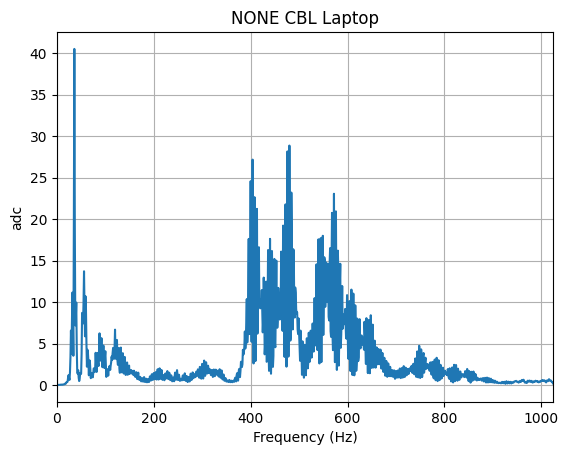

In [37]:
f,p2 = xxx.PlotFFT(data, 1024)

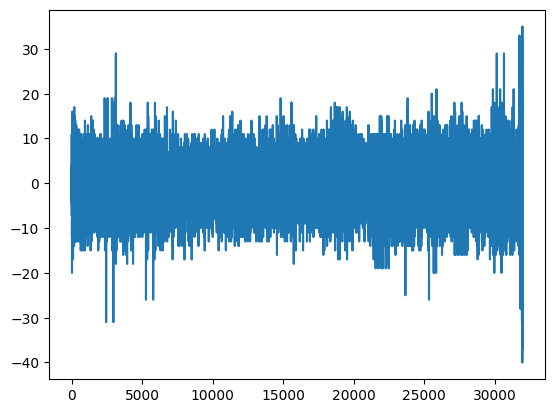

In [38]:
plt.plot(data[32768:64736])

In [13]:
def AbsMag2(datain):
    """
    data in is complex, don't quite know hot to cast this. 
    """
    N = int(len(datain)/2)
    dataout = np.zeros(N)
    cindex = 0
    for i in range(0,N):
        dataout[i] = np.power(datain[cindex],2) + np.power(datain[cindex+1],2)
        cindex = cindex + 2
    return dataout

In [14]:
# Check on the status of how the FFT in the main program is running. 
# open up the logfiles
FFTPath = '/Users/clirakis/code/Audio/'
FFTFile = '250619_124300.FFT'
Filespec = FFTPath + FFTFile
fd = open(Filespec, "rb")
# Read in the whole file. 
# how many bytes in the file??
fd.seek(0,2) # got to end of file
DataSizeBytes = fd.tell() 
fd.seek(0)        # rewind
data = fd.read(DataSizeBytes)
data_format = str(int(DataSizeBytes/8))+'d'
(Ddata) = struct.unpack(data_format,data)
fd.close()
# now you have the complex data. 

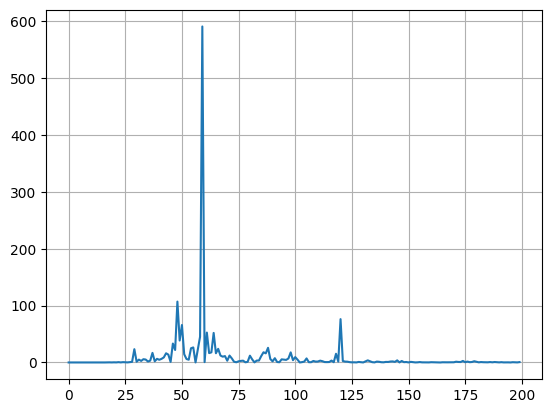

In [16]:
y = AbsMag2(Ddata)
y = y/np.power(2048,2)
plt.plot(y[0:200])
plt.grid()

In [14]:
# Check the alarm data
# Check on the status of how the FFT in the main program is running. 
# open up the logfiles
FFTPath = '/Users/clirakis/code/Audio/'
FFTFile = 'absm2_09.dat' 
Filespec = FFTPath + FFTFile
fd = open(Filespec, "rb")
# Read in the whole file. 
# how many bytes in the file??
fd.seek(0,2) # got to end of file
DataSizeBytes = fd.tell() 
fd.seek(0)        # rewind
data = fd.read(DataSizeBytes)
data_format = str(int(DataSizeBytes/8))+'d'
(Ddata) = struct.unpack(data_format,data)
fd.close()
#

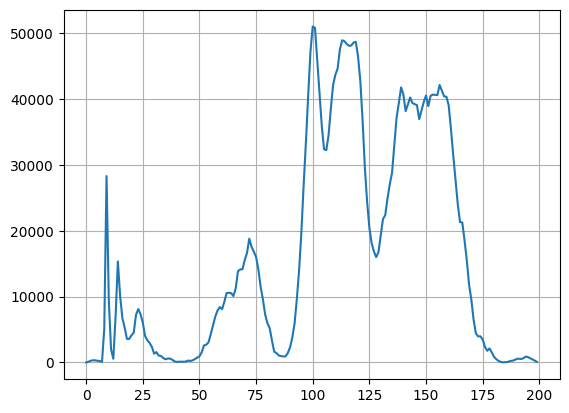

In [15]:
plt.plot(Ddata)
plt.grid()

In [40]:
s = np.sum(Ddata)/200
print(s)

0.07599108230854468
